# Chapter 2: Reservoir Fluid Properties (Correlations)
**Author:**

**Objective:**
In this notebook, we will build Python functions to calculate key fluid properties using empirical correlations found in Tarek Ahmed's *Reservoir Engineering Handbook*.

**Scope:**
1.  **Gas Z-Factor:** Using the Dranchuk-Abou-Kassem (DAK) method to digitally reproduce the **Standing-Katz Chart**.
2.  **Bubble Point Pressure ($P_b$):** Implementing **Vasquez-Beggs** and **Glaso** correlations.
3.  **Oil Viscosity ($\mu_o$):** Implementing **Beggs-Robinson** and **Vasquez-Beggs** correlations.

These functions are critical because real lab data (PVT reports) is often missing or incomplete. These correlations allow us to estimate properties based on simple field data like **Gas Specific Gravity ($\gamma_g$)**, **Oil Gravity (API)**, and **Gas-Oil Ratio ($R_s$)**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Gas Compressibility Factor (Z-Factor)

The Z-factor corrects the Ideal Gas Law for real gas behavior: $PV = ZnRT$.

While the **Standing-Katz chart** is the industry standard, we cannot "read" a chart in Python. Instead, we use the **Dranchuk-Abou-Kassem (DAK)** equation of state, which fits the Standing-Katz chart with high accuracy.

### The Math (DAK Method)
The correlation solves for reduced density $\rho_r$ iteratively:
$$Z = 1 + (A_1 + \frac{A_2}{T_{pr}} + \frac{A_3}{T_{pr}^3} + \dots)\rho_r + \dots$$

Where:
* $T_{pr} = \text{Pseudo-Reduced Temperature}$
* $P_{pr} = \text{Pseudo-Reduced Pressure}$

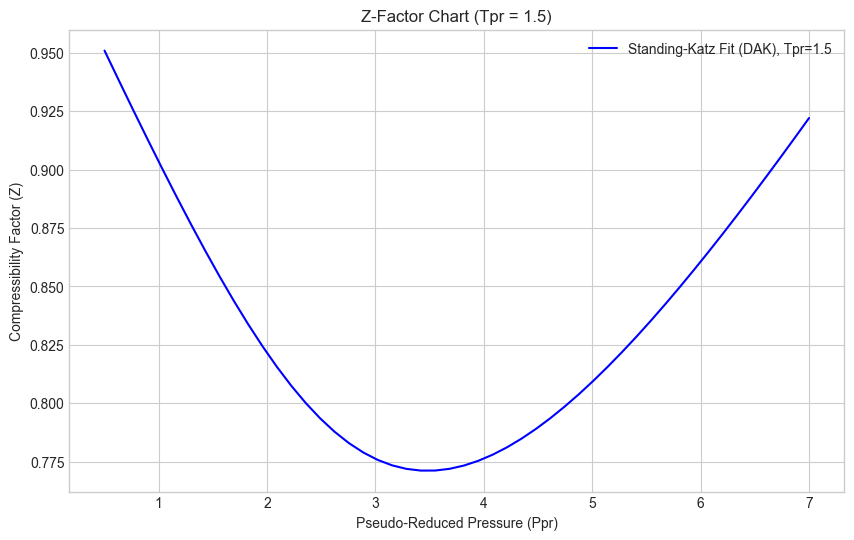

In [2]:
def calculate_z_factor(P_pr, T_pr):
    """
    Calculates Gas Z-Factor using Dranchuk-Abou-Kassem (DAK) correlation.
    Fits the Standing-Katz chart.
    
    Args:
        P_pr (float): Pseudo-reduced Pressure (dimensionless)
        T_pr (float): Pseudo-reduced Temperature (dimensionless)
        
    Returns:
        z (float): Gas Compressibility Factor
    """
    # DAK Coefficients
    A1 = 0.3265
    A2 = -1.0700
    A3 = -0.5339
    A4 = 0.01569
    A5 = -0.05165
    A6 = 0.5475
    A7 = -0.7361
    A8 = 0.1844
    A9 = 0.1056
    A10 = 0.6134
    A11 = 0.7210

    # The implicit equation for reduced density (rho_r)
    # We solve f(rho_r) = 0
    def dak_equation(rho_r):
        R1 = A1 + A2/T_pr + A3/(T_pr**3) + A4/(T_pr**4) + A5/(T_pr**5)
        R2 = A6 + A7/T_pr + A8/(T_pr**2)
        R3 = A9 * (A7/T_pr + A8/(T_pr**2))
        
        # The main equation: Z = ... -> rewrite in terms of rho_r
        # Z = 0.27 * P_pr / (rho_r * T_pr)
        # 0.27 * P_pr / (rho_r * T_pr) = 1 + R1*rho_r + R2*rho_r^2 - R3*rho_r^5 + ...
        
        # Rearranging f(rho_r) = 0
        term1 = R1 * rho_r
        term2 = R2 * rho_r**2
        term3 = R3 * rho_r**5
        term4 = A10 * (1 + A11 * rho_r**2) * (rho_r**2 / (T_pr**3)) * np.exp(-A11 * rho_r**2)
        
        Z_calc = 1 + term1 + term2 - term3 + term4
        
        # Difference between Z calculated from EOS and Z definition
        return Z_calc - (0.27 * P_pr / (rho_r * T_pr))

    # Initial guess for rho_r (0.27 * P_pr / T_pr is a good guess for ideal gas)
    initial_guess = 0.27 * P_pr / T_pr
    
    # Solve for rho_r
    rho_r_solution = fsolve(dak_equation, initial_guess)[0]
    
    # Calculate final Z
    z = (0.27 * P_pr) / (rho_r_solution * T_pr)
    return z

# --- EXERCISE: Recreate a Standing-Katz Isotherm ---
T_pseudo = 1.5 # Fixed Tpr
P_pseudo_range = np.linspace(0.5, 7.0, 50)
z_values = [calculate_z_factor(P, T_pseudo) for P in P_pseudo_range]

plt.plot(P_pseudo_range, z_values, 'b-', label=f'Standing-Katz Fit (DAK), Tpr={T_pseudo}')
plt.xlabel('Pseudo-Reduced Pressure (Ppr)')
plt.ylabel('Compressibility Factor (Z)')
plt.title(f'Z-Factor Chart (Tpr = {T_pseudo})')
plt.legend()
plt.grid(True)
plt.show()

## 2. Bubble Point Pressure ($P_b$)

The Bubble Point is the pressure at which gas first starts to evolve from oil. We will implement two classic correlations:

1.  **Vasquez-Beggs (1980):** Generally accurate for heavy to medium oils. It uses different coefficients for API > 30 and API $\leq$ 30.
2.  **Glaso (1980):** Developed for North Sea volatile oils.

### The Equations
Both correlations rely on:
* $R_s$: Solution Gas-Oil Ratio (scf/STB)
* $\gamma_g$: Gas Specific Gravity
* $T$: Reservoir Temperature (°F)
* $API$: Oil Gravity

In [3]:
def calc_pb_vasquez_beggs(Rs, gamma_g, API, T_degF):
    """
    Calculates Bubble Point Pressure using Vasquez-Beggs (1980).
    """
    # 1. Constants based on API
    if API <= 30:
        C1, C2, C3 = 0.0362, 1.0937, 25.7240
    else:
        C1, C2, C3 = 0.0178, 1.1870, 23.931
        
    # 2. Gas Gravity Correction (if needed) - simplified here as gamma_gs = gamma_g
    # In practice, Vasquez-Beggs suggests correcting gas gravity to separator pressure
    # We will use the input gamma_g directly for this exercise.
    
    # 3. Calculate Pb
    # Formula: Pb = [ Rs / (C1 * gamma_g * exp(C3 * API / (T + 460))) ] ^ (1 / C2)
    
    term1 = C1 * gamma_g * np.exp((C3 * API) / (T_degF + 460))
    pb = (Rs / term1)**(1 / C2)
    
    return pb

def calc_pb_glaso(Rs, gamma_g, API, T_degF):
    """
    Calculates Bubble Point Pressure using Glaso (1980).
    """
    # Glaso uses a logarithmic fit equation
    
    # Calculate 'A' exponent term
    # A = (Rs / gamma_g)^0.816 * (T^0.172) * (API^-0.989)
    # Note: Glaso equation usually requires T in F, but the correlation structure varies in literature.
    # Standard form in Tarek Ahmed:
    
    exponent_val = (Rs / gamma_g)**0.816 * (T_degF**0.172) * (API**-0.989)
    
    # Calculate Pb* (intermediate value)
    # log(Pb*) = 1.7669 + 1.7447*log(A) - 0.3218*log(A)^2
    log_A = np.log10(exponent_val)
    log_Pb_star = 1.7669 + 1.7447 * log_A - 0.3218 * (log_A**2)
    
    Pb_star = 10**log_Pb_star
    
    return Pb_star

## 3. Oil Viscosity ($\mu_o$)

Viscosity depends heavily on pressure. We usually calculate it in three steps:

1.  **Dead Oil Viscosity ($\mu_{od}$):** Viscosity at atmospheric pressure (no gas).
2.  **Saturated Oil Viscosity ($\mu_{ob}$):** Viscosity at Bubble Point (gas dissolved).
3.  **Undersaturated Oil Viscosity ($\mu_o$):** Viscosity above Bubble Point.

We will use:
* **Beggs-Robinson:** For Dead and Saturated Oil.
* **Vasquez-Beggs:** For Undersaturated Oil (Pressure > $P_b$).

In [4]:
def calc_viscosity_beggs_robinson(API, T_degF, Rs):
    """
    Calculates Saturated Oil Viscosity using Beggs-Robinson (1975).
    """
    # 1. Dead Oil Viscosity (mu_od)
    # mu_od = 10^(x) - 1
    # x = y * T^(-1.163)
    # y = 10^(3.0324 - 0.02023 * API)
    
    y = 10**(3.0324 - 0.02023 * API)
    x = y * (T_degF**(-1.163))
    mu_od = 10**x - 1
    
    # 2. Saturated Viscosity (mu_ob) at Pb
    # mu_ob = A * (mu_od ^ B)
    # A = 10.715 * (Rs + 100)^(-0.515)
    # B = 5.44 * (Rs + 150)^(-0.338)
    
    A = 10.715 * ((Rs + 100)**-0.515)
    B = 5.44 * ((Rs + 150)**-0.338)
    
    mu_ob = A * (mu_od**B)
    
    return mu_od, mu_ob

def calc_viscosity_vasquez_beggs_undersat(mu_ob, P, Pb):
    """
    Calculates Undersaturated Oil Viscosity (P > Pb) using Vasquez-Beggs (1980).
    """
    if P <= Pb:
        return mu_ob
        
    # mu = mu_ob * (P / Pb)^m
    # m = 2.6 * P^1.187 * exp(-11.513 - 8.98e-5 * P) 
    # NOTE: The 'm' parameter correlation varies. Tarek Ahmed lists:
    # m = A * P^B ... check exact correlation
    
    # Common form: m = 2.6 * (P**1.187) * np.exp(-11.513 - (8.98e-5 * P)) is mostly for CO2
    # The standard Vasquez-Beggs oil viscosity update is:
    # m = C1 * P^C2 * exp(C3 + C4*P) ...
    # Let's use the simplified version often found in standard texts for general oil:
    
    m = 2.6 * (P**1.187) * np.exp(-11.513 - (8.98e-5 * P))
    
    mu_o = mu_ob * ((P / Pb)**m)
    return mu_o

## 4. Master Comparison: Putting it all together

Let's imagine we have a reservoir fluid sample with the following data and we want to see how the properties vary across a pressure range.

**Input Data:**
* $T = 200^\circ F$
* $API = 35$
* $\gamma_g = 0.8$
* $R_s = 600$ scf/STB

--- Bubble Point Pressure ($P_b$) ---
Vasquez-Beggs: 2702.43 psi
Glaso:         2578.78 psi


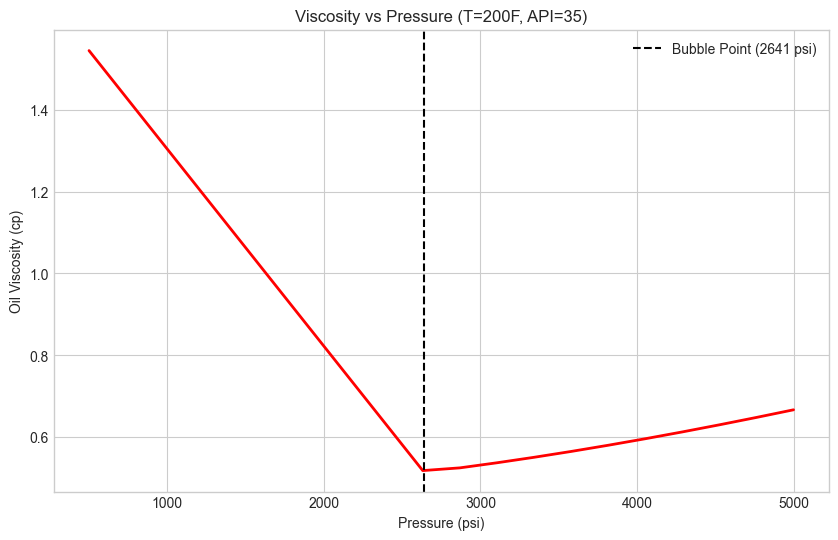

In [5]:
# --- INPUTS ---
Temp = 200
API_grav = 35
gamma_gas = 0.8
Rs_solution = 600

# 1. Calculate Bubble Point
Pb_VB = calc_pb_vasquez_beggs(Rs_solution, gamma_gas, API_grav, Temp)
Pb_Gl = calc_pb_glaso(Rs_solution, gamma_gas, API_grav, Temp)

print(f"--- Bubble Point Pressure ($P_b$) ---")
print(f"Vasquez-Beggs: {Pb_VB:.2f} psi")
print(f"Glaso:         {Pb_Gl:.2f} psi")

# 2. Calculate Viscosity at different Pressures
pressures = np.linspace(500, 5000, 20)
viscosities = []

# Get base viscosities
mu_od, mu_ob = calc_viscosity_beggs_robinson(API_grav, Temp, Rs_solution)

# Assume the calculated Pb is the average of the two methods for this plot
Pb_avg = (Pb_VB + Pb_Gl) / 2

for P in pressures:
    if P < Pb_avg:
        # Below Pb, viscosity generally increases as gas comes out of solution
        # Simplified assumption for plot: Linear interpolation between dead oil and sat oil
        # (Real life requires Rs at that specific pressure)
        slope = (mu_ob - mu_od) / Pb_avg
        mu = mu_od + slope * P
    else:
        # Above Pb, use Undersaturated correlation
        mu = calc_viscosity_vasquez_beggs_undersat(mu_ob, P, Pb_avg)
    viscosities.append(mu)

# Plotting
plt.figure()
plt.plot(pressures, viscosities, 'r-', linewidth=2)
plt.axvline(Pb_avg, color='k', linestyle='--', label=f'Bubble Point ({Pb_avg:.0f} psi)')
plt.xlabel('Pressure (psi)')
plt.ylabel('Oil Viscosity (cp)')
plt.title(f'Viscosity vs Pressure (T={Temp}F, API={API_grav})')
plt.legend()
plt.grid(True)
plt.show()